# **Apply transformer-based LLM models for text classfication applications**


##  Sentiment Analysis on Financial News Headlines using large language models

# **Objective**

#### This analysis aims at predicting sentiments from financial news headlines leveraging pre-trained transformer-based model hosted on Huggingface.


The LLM model selected here is DistilBERT model that can be used for text classification including Sentiment Analysis. DistilBert is a relative simpler model than BERT or RoBERTa.


DistilBERT stands for "Bidirectional Encoder Representations from Transformers)



In [ ]:
# Setup Google Colab dev
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Check for GPU resource (Optional)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ff35728a-8e81-fba3-1119-92f8034c72ef)


# **Import Python Libraries**

In [ ]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup
import random


from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # after TensorFlow 2.6
from tensorflow.keras import layers
import tensorflow_hub as hub


from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import mean_squared_error


In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 5)
!pip install transformers simpletransformers nltk

In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 5)
!pip install accelerate -U

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer

from datasets import load_dataset
from datasets import load_metric

#### Enable Display Ipython full output in cells

In [ ]:
#Enable displaying full Ipython output
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# **Load Financial News Sentiment Text Dataset**

### This dataset contains the sentiments for financial news headlines from the perspective of a retail investor.

## it contains news text and Multiple sentiment ratings:

> -- **Positive**

> -- **Negative**

> -- **Neutral**



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('all-data.csv',delimiter=',',header=None, encoding='latin-1')
df = df.rename(columns={0:'sentiment',1:'text'})
df.head(6)

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


# **EDA: Data Exploration and Cleaning**

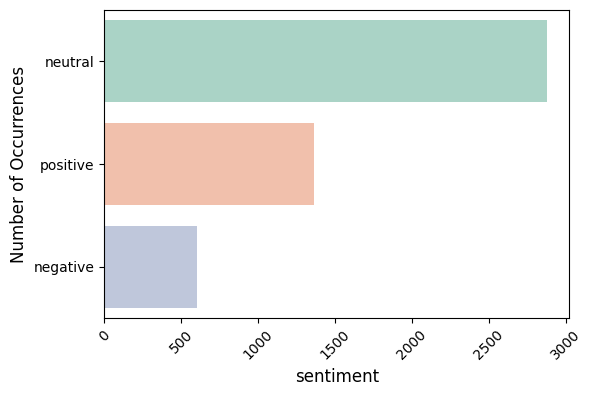

In [ ]:
news_count = df['sentiment'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(y = news_count.index, x = news_count.values, alpha=0.6, palette = "Set2",orient='h')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show();

#### Convert String Labels into numeric values

# **Modeling to Predict Sentiment in the Financial News**

This analysis focus on large language models.


However, previously, I've done a seperate analysis to apply various classic machine learning predictive models and Deep learning models to the same dataset to predict sentiment. That analysis can be found here: https://github.com/mojocraftdojo/NLP_news_sentiment_analysis


Those models can be used as a baseline to compare with performance of LLMs.

>### **Classic Supervised learning models( Scikit-learn)**
>> #### Model 0: Naive Bayes (baseline)
>> #### Model 1: Random Forest
>> #### Model 2: XGBoost
>> #### Model 3: Support Vector Machine
>> #### Model 4: Logistic Regression

>### **Deep Learning with NLP text preprocessing (TensorFlow/Keras)**
>>#### Model 5: RNNs (LSTM)
>>#### Model 6: TensorFlow Hub Pretrained Feature Extractor (Transfer Learning use USE)

# **Large Language Models(LLM)**

## **Transformers based DistilBERT Base Model (hosted on Huggingface)**

## **Tokenization**

Use transformers tokenizers to convert a sequence of text into individual units, or tokens

In [ ]:
##load the data
dataset = load_dataset('csv',
                        data_files={'train': 'train_subset.csv',
                        'validation': 'validation_subset.csv',
                        'test': 'test_subset.csv'})

dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 3100
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 776
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 970
    })
})

In [ ]:
# Use Distilbert model
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# tokenize the dataset for the model to be able to understand text
def tokenize_data(example):
    return tokenizer(example['text'], padding='max_length')

In [ ]:
## tokenize the whole dataset
dataset = dataset.map(tokenize_data, batched=True)
dataset

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 3100
    })
    validation: Dataset({
        features: ['labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 776
    })
    test: Dataset({
        features: ['labels', 'text', 'input_ids', 'attention_mask'],
        num_rows: 970
    })
})

## **Training and Hyperprameter tuning**

### Pretrained models in hugging face to choose from, with different complexity (DistilBERT, BERT, RoBERTa)

In [ ]:
### Choose DistilBERT model architecture for simplicity
from transformers import AutoModelForSequenceClassification

# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3) #here num_labes =3 because of the 3 classes of sentiment


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## **Training Arguments Configuration**

In [ ]:
# the default batch size for training arguments
batch_size = 8

# set number of epochs
number_of_epochs = 7
# let set the logging steps
logging_steps = len(dataset['train']) // batch_size # it should log each batch

steps = (len(dataset['train']) / batch_size) * number_of_epochs
warmup_steps = int(0.2 * steps)



from transformers import TrainingArguments
training_args = TrainingArguments(
                                  num_train_epochs=number_of_epochs,
                                  load_best_model_at_end=True,
                                  evaluation_strategy='steps',
                                  save_strategy='steps',
                                  learning_rate=2e-5,
                                  logging_steps=logging_steps,
                                  warmup_steps= warmup_steps,
                                  save_steps=1000,
                                  eval_steps=500,
                                  seed=42,
                                  output_dir="fine-tuned-distilbert-base-uncased"
                                  )


## **Model Training**

In [ ]:
# shuffle the datasets

train_dataset = dataset['train'].shuffle(seed=10)
validation_dataset = dataset['validation'].shuffle(seed=10)

In [ ]:
### create an Trainer Instance
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=validation_dataset
)

trainer

## **MOdel Evaluation Metrics**

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from datasets import load_metric


def compute_metrics(eval_pred):
    # load the metrics to use
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculate the mertic using the predicted and true value
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)
    f1 = load_f1.compute(predictions=predictions, references=labels, average="weighted")
    return {"accuracy": accuracy, "f1score": f1}

In [ ]:
# Launch the learning process: training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=compute_metrics,

)

In [ ]:
### start traning
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1score
500,0.781100,0.440757,{'accuracy': 0.8182989690721649},{'f1': 0.8204753398612111}
1000,0.402500,0.583777,{'accuracy': 0.8402061855670103},{'f1': 0.8404854825757347}
1500,0.234700,0.844276,{'accuracy': 0.8350515463917526},{'f1': 0.835274143418472}
2000,0.092600,0.826111,{'accuracy': 0.8389175257731959},{'f1': 0.8396491506112066}
2500,0.057000,0.866652,{'accuracy': 0.8440721649484536},{'f1': 0.8438066510677654}


<ipython-input-131-92e71db27ddc>:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


Trainer is attempting to log a value of "{'accuracy': 0.8182989690721649}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8204753398612111}" of type <class 'dict'> for key "eval/f1score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8402061855670103}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8404854825757347}" of type <class 'dict'> for key "eval/f1score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.8350515463917526}" of type <class 

TrainOutput(global_step=2716, training_loss=0.2483536675682124, metrics={'train_runtime': 1129.6581, 'train_samples_per_second': 19.209, 'train_steps_per_second': 2.404, 'total_flos': 2874593814220800.0, 'train_loss': 0.2483536675682124, 'epoch': 7.0})

## **Evaluate on validation set**

In [ ]:
# Launch the final evaluation
trainer. evaluate()

Trainer is attempting to log a value of "{'accuracy': 0.8402061855670103}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.8404854825757347}" of type <class 'dict'> for key "eval/f1score" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.583776593208313,
 'eval_accuracy': {'accuracy': 0.8402061855670103},
 'eval_f1score': {'f1': 0.8404854825757347},
 'eval_runtime': 14.1834,
 'eval_samples_per_second': 54.712,
 'eval_steps_per_second': 6.839,
 'epoch': 7.0}